## On-Sky image with annotations

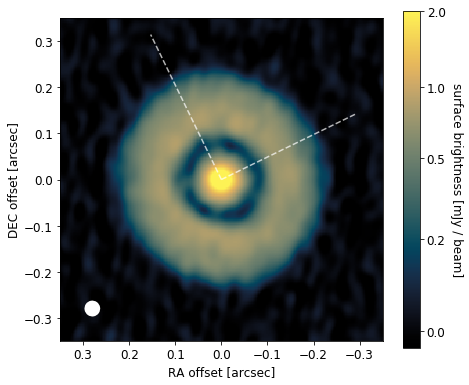

In [53]:
import os, sys, time           
import numpy as np             
from astropy.io import fits      
import urllib.request          
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import cmasher as cmr          
from astropy.visualization import (AsinhStretch, LogStretch, ImageNormalize)
%matplotlib inline                

# set color map
cmap = cmr.eclipse

# set font size everywhere
plt.rc('font', size=12)



# disk target name
disk_name = 'SR4'

# geometric properties (fixed by previous efforts)
offRA, offDEC = -0.060, -0.509
incl, PA = 22., 26.
inclr, PAr = np.radians(incl), np.radians(PA)
rout = 0.35


# set this to your project directory (or however you like)
working_dir = '/Users/sandrews/Desktop/DSHARP_CPDs/data/'

# if you don't already have the datafile, download it
if not os.path.exists(working_dir+disk_name+'_continuum.fits'):
    dsharp_url = 'https://bulk.cv.nrao.edu/almadata/lp/DSHARP/images/'+disk_name+'_continuum.fits'
    urllib.request.urlretrieve(dsharp_url, working_dir+disk_name+'_continuum.fits')

# load the .FITS file contents
data = fits.open(working_dir+disk_name+'_continuum.fits')
image = np.squeeze(data[0].data)
header = data[0].header

# parse coordinate frame indices into physical numbers
nx, ny = header['NAXIS1'], header['NAXIS2']
RA = header['CRVAL1'] + header['CDELT1'] * (np.arange(nx) - (header['CRPIX1'] - 1))
DEC = header['CRVAL2'] + header['CDELT2'] * (np.arange(ny) - (header['CRPIX2'] - 1))
RAo, DECo = 3600 * (RA - header['CRVAL1']), 3600 * (DEC - header['CRVAL2'])
RAo_shift, DECo_shift = RAo - offRA, DECo - offDEC
dRA, dDEC = np.meshgrid(RAo_shift, DECo_shift)
freq = header['CRVAL3']

# beam parameters 
beam_maj, beam_min, beam_PA = 3600 * header['BMAJ'], 3600 * header['BMIN'], header['BPA']
beam_area = (np.pi * beam_maj * beam_min / (4 * np.log(2))) / (3600 * 180 / np.pi)**2

# image setups
im_bounds = (dRA.max(), dRA.min(), dDEC.min(), dDEC.max())
dRA_lims, dDEC_lims = [rout, -rout], [-rout, rout]

# intensity limits, and stretch
cmap = cmr.eclipse
vmin, vmax = -0.03, 2.0    # these are in mJy/beam units
norm = ImageNormalize(vmin=vmin, vmax=vmax, stretch=AsinhStretch())

# image plot
fig, ax = plt.subplots(figsize=(7, 5.5))
im = ax.imshow(1e3*image, origin='lower', cmap=cmap, extent=im_bounds, norm=norm, aspect='equal')

# annotations
rmaj = np.linspace(0, rout, 10)
ax.plot(rmaj * np.sin(PAr), rmaj * np.cos(PAr), '--w', alpha=0.7)    # major axis (theta = 90)
ax.plot(rmaj * np.cos(inclr) * np.sin(PAr - 0.5*np.pi), 
        rmaj * np.cos(inclr) * np.cos(PAr - 0.5*np.pi), '--w', alpha=0.7)    # minor axis (theta = 0)

# limits, labeling
ax.set_xlim(dRA_lims)
ax.set_ylim(dDEC_lims)
ax.set_xlabel('RA offset [arcsec]')
ax.set_ylabel('DEC offset [arcsec]')

# scalebar
cb = plt.colorbar(im, ax=ax, pad=0.05)
cb.set_ticks([0, 0.2, 0.5, 1.0, 2.0])
cb.set_label('surface brightness [mJy / beam]', rotation=270, labelpad=17)

# beam
beam = Ellipse((dRA_lims[0] + 0.1*np.diff(dRA_lims), dDEC_lims[0] + 0.1*np.diff(dDEC_lims)), 
                beam_maj, beam_min, 90-beam_PA)
beam.set_facecolor('w')
ax.add_artist(beam)

# adjust layout
fig.subplots_adjust(left=0.13, right=0.93, bottom=0.13, top=0.98)

In [54]:
fig.savefig('../figs/'+disk_name+'_image.pdf')

## Deprojected Radius-Azimuth Map 

In [47]:
sys.path.append('../')
from razmap import razmap

# define (r, az) bins for deprojected image
cellsize = np.abs(header['CDELT1'] * 3600)
rbins = np.arange(cellsize, 1.2 * rout, cellsize)    # in arcseconds
tbins = np.linspace(-180, 180, 181)                  # in degrees

# perform the deprojection
deproj = razmap(working_dir+disk_name+'_continuum.fits', rbins, tbins, incl=incl, PA=PA, offx=offRA, offy=offDEC)
raz_im = deproj.raz_map

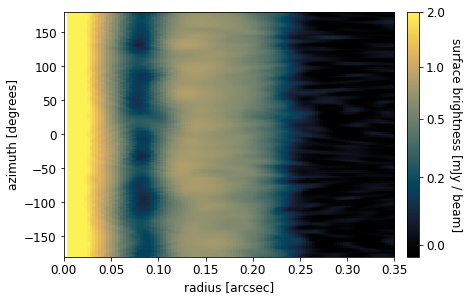

In [50]:
# image setups
rtmap_bounds = (rbins.min(), rbins.max(), tbins.min(), tbins.max())
t_lims = [tbins.min(), tbins.max()]      
r_lims = [0, rout]

# set up and plot the images on the specified scale
fig, ax = plt.subplots(figsize=(7, 4))
im = ax.imshow(1e3*raz_im, origin='lower', cmap=cmap, extent=rtmap_bounds, norm=norm, aspect='auto')
ax.set_xlim(r_lims)
ax.set_ylim(t_lims)
#ax.grid()
ax.set_ylabel('azimuth [degrees]')
ax.set_xlabel('radius [arcsec]')

# add a scalebar
cb = plt.colorbar(im, ax=ax, pad=0.03)
cb.set_ticks([0, 0.2, 0.5, 1.0, 2.0])
cb.set_label('surface brightness [mJy / beam]', rotation=270, labelpad=17)

# adjust layout
fig.subplots_adjust(left=0.13, right=0.93, bottom=0.13, top=0.98)

In [51]:
fig.savefig('../figs/'+disk_name+'_razmap.pdf')

## Visibility Modeling 

In [57]:
from frank.radial_fitters import FrankFitter
from frank.geometry import FixedGeometry
from frank.io import save_fit

# load the visibility data
dat = np.load(working_dir+disk_name+'_continuum.vis.npz')
u, v, vis, wgt = dat['u'], dat['v'], dat['Vis'], dat['Wgt']

# set the disk viewing geometry
geom = FixedGeometry(incl, PA, dRA=offRA, dDec=offDEC)

# set the frankenstein hyper-parameters
Rmax  = 0.5    # this is ~1.5x the maximum radius where we see emission (in arcseconds)
Ncoll = 300    # this is the # of collocation points used in the model 
alpha = 1.3    # this controls how much noisy data is included in the fit   
wsmth = 0.1    # this controls how much the fit smooths over oscillations

# configure the fitting code setup
FF = FrankFitter(Rmax=Rmax, N=Ncoll, geometry=geom, alpha=alpha, weights_smooth=wsmth)

# fit the visibilities
sol = FF.fit(u, v, vis, wgt)

# save the fit
save_fit(u, v, vis, wgt, sol, prefix='../fits/'+disk_name+'_continuum')

Text(0, 0.5, '$T_b \\,\\,$ [K]')

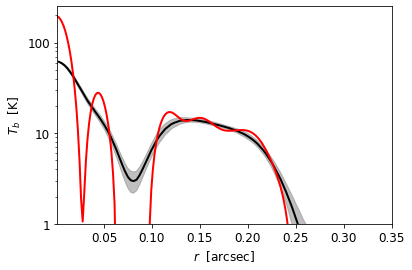

In [103]:
# load frankenstein radial brightness profile fit
SBfile_name = '../fits/'+disk_name+'_continuum_frank_profile_fit.txt'
r_frank, Inu_frank = np.loadtxt(SBfile_name, usecols=(0, 1)).T

# convert to brightness temperatures (R-J limit)
kB_, c_ = 1.38064852e-16, 2.99792e10
Tb_frank = c_**2 * 1e-23 * Inu_frank / (2 * kB_ * freq**2)

# convert CLEAN map profile to brightness temperatures (R-J limit)
Tb_data = c_**2 * 1e-23 * deproj.prof / beam_area / (2 * kB_ * freq**2)
eTb_data = c_**2 * 1e-23 * deproj.eprof / beam_area / (2 * kB_ * freq**2)

fig, ax = plt.subplots()
ax.fill_between(deproj.r, Tb_data-eTb_data, Tb_data+eTb_data, color='gray', alpha=0.5)
ax.plot(deproj.r, Tb_data, 'k', lw=2)
ax.plot(r_frank, Tb_frank, 'r', lw=2)
ax.set_xlim([0.001, rout])
ax.set_ylim([1., 250])
ax.set_yscale('log')
ax.set_yticks([1, 10, 100])
ax.set_yticklabels(['1', '10', '100'])
ax.set_xlabel('$r \,\,$ [arcsec]')
ax.set_ylabel('$T_b \,\,$ [K]')